# Evaluating docker image libraries embedding : library seq2seq

This notebook evaluates the quality of a library embedding by trying to estimate installed native packages from python packages.

It expects the swivel embedding to be accessible in a `./swivel_data` folder, and the result of dockerhub_crawler to be accessible in a `./packages` folder.

The model is a keras LSTM, primarly to test the sequence pipeline, I wanted to use a tranformer network but did not have the time to achieve it.

In [1]:
import pandas as pd
em = pd.read_csv("./swivel_input/row_embedding.tsv", sep="\t", index_col=0, header=None)
em.dropna()
em.head()

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
inherits,-0.002074,-0.055387,0.071120,-0.045559,0.038971,0.127233,0.097771,-0.023708,-0.067608,0.028490,...,-0.006313,0.189044,-0.085521,-0.284779,0.030715,-0.012504,-0.053607,0.125696,-0.036647,0.027605
debug,0.095724,-0.094275,0.029039,0.051519,-0.170617,0.059262,-0.221052,-0.064412,-0.063616,-0.006391,...,0.113163,-0.492995,-0.024613,-0.021880,-0.005242,-0.376428,0.174471,-0.003131,0.054965,-0.161302
babel-runtime,-0.025974,0.041949,-0.063270,0.032456,0.238778,-0.064798,-0.183525,0.323302,0.099423,-0.123717,...,0.363400,0.326705,-0.140737,0.016890,0.238949,-0.310610,-0.001889,-0.125260,0.133748,0.117960
readable-stream,-0.216100,-0.046885,-0.124645,0.044255,-0.014279,0.018678,0.021243,-0.128286,0.018869,0.045507,...,-0.277873,0.028376,0.036960,-0.062313,0.011647,0.079347,0.068455,0.338613,-0.029285,-0.123254
graceful-fs,-0.032099,0.301070,-0.068095,0.048428,-0.167309,-0.113752,-0.068540,-0.003886,0.022903,-0.011084,...,-0.051891,0.000703,-0.203847,-0.013092,0.013126,0.168928,-0.067377,0.081078,0.086696,0.161362


In [2]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [3]:
packages_list = !find packages -type f
import json
def get_images_libs():
    for path in packages_list:
        package_name = path[13:]
        with open(path) as json_file:
            try:
                package = json.load(json_file)
                native_libs = [natpack[0] for natpack in package["packages"]["native"]]
                python_libs = [natpack[0] for natpack in package["packages"]["python3"]]
                node_libs = [natpack[0] for natpack in package["packages"]["node"]]
                image = {
                    "name": package['image'],
                    "distro": package['distribution'],
                    "size": package["size"],
                    "python": python_libs,
                    "node": node_libs,
                    "native": native_libs,
                }
                yield image
            except Exception as e:
                #print(e)
                pass

In [4]:
from tqdm import tqdm
images_libs = [image for image in tqdm(get_images_libs())]

31754it [00:18, 1722.31it/s]


In [5]:
len(images_libs)

31754

In [6]:
libs = !cat ./swivel_input/row_vocab.txt

In [28]:
def train_test_split(images_libs, ratio=0.2):
    test_libs = set(libs[-int(len(libs)*ratio):])
    train_images = []
    test_images = []
    for image in images_libs:
        if (set(image['python']) | set(image['node']) | set(image['native']) ) & test_libs:
            test_images.append(image)
        else:
            train_images.append(image)
    return train_images, test_images

In [29]:
train, test = train_test_split(images_libs)

In [30]:
print(len(train), len(test))

26913 4841


In [31]:
import numpy as np
def assign_library_vectors(images):
    count = 0
    for image in tqdm(images):
        count += 1
        try:
            vectors = [em.loc[lib].values for lib in image['python']]
            image['python_embedding'] = np.array(vectors)
            vectors = [em.loc[lib].values for lib in image['node']]
            image['node_embedding'] = np.array(vectors)
            vectors = [em.loc[lib].values for lib in image['native']]
            image['native_embedding'] = np.array(vectors)
        except Exception as e:
            pass

In [32]:
assign_library_vectors(train)
assign_library_vectors(test)

100%|██████████| 4841/4841 [02:27<00:00, 32.87it/s]


In [33]:
test = pd.DataFrame(test)
train = pd.DataFrame(train)
test = test.dropna()
train = train.dropna()
test_save = test
train_save = train
train.head()

,distro,name,native,native_embedding,node,node_embedding,python,python_embedding,size
0,debian,bponath/mynginx:latest,"[acl, adduser, apt, base-files, base-passwd, b...","[[-0.08631343400000001, -0.18472953, -0.246940...",[],[],[],[],200660
1,alpine,bpatel13/myfirstapp:latest,"[musl, busybox, alpine-baselayout, alpine-keys...","[[0.04535544, -0.014450148000000001, -0.015615...",[],[],[],[],69148
2,alpine,bpedazur/test-node:latest,"[musl, busybox, alpine-baselayout, alpine-keys...","[[0.04535544, -0.014450148000000001, -0.015615...","[npm, abbrev, ansi-regex, ansicolors, ansistyl...","[[-0.0024395436, 0.22081888, 0.16611862, 0.122...",[],[],75340
3,debian,bpapman/catnip:latest,"[acl, adduser, apt, autoconf, automake, autoto...","[[-0.08631343400000001, -0.18472953, -0.246940...",[],[],[],[],732660
4,debian,bpkp/jenkins:latest,"[acl, adduser, apt, base-files, base-passwd, b...","[[-0.08631343400000001, -0.18472953, -0.246940...",[],[],[],[],802016


In [40]:
train[train.apply(lambda x: len(x['python']) != 0 , axis=1)].info()
#test = test[test.apply(lambda x: len(x['python']) != 0, axis=1)]
#train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1260 entries, 43 to 26878
Data columns (total 9 columns):
distro              1260 non-null object
name                1260 non-null object
native              1260 non-null object
native_embedding    1260 non-null object
node                1260 non-null object
node_embedding      1260 non-null object
python              1260 non-null object
python_embedding    1260 non-null object
size                1260 non-null int64
dtypes: int64(1), object(8)
memory usage: 98.4+ KB


In [41]:
print(train.info(), test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1260 entries, 43 to 26878
Data columns (total 9 columns):
distro              1260 non-null object
name                1260 non-null object
native              1260 non-null object
native_embedding    1260 non-null object
node                1260 non-null object
node_embedding      1260 non-null object
python              1260 non-null object
python_embedding    1260 non-null object
size                1260 non-null int64
dtypes: int64(1), object(8)
memory usage: 98.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 70 to 4806
Data columns (total 9 columns):
distro              182 non-null object
name                182 non-null object
native              182 non-null object
native_embedding    182 non-null object
node                182 non-null object
node_embedding      182 non-null object
python              182 non-null object
python_embedding    182 non-null object
size                182 non-null int64
dtypes: 

Creating Features and targets

In [51]:
from keras.preprocessing.sequence import pad_sequences
# Getting numpy arrays from pandas
X_train = train['python_embedding'].values
y_train = train['native_embedding'].values
X_test = test['python_embedding'].values
y_test = test['native_embedding'].values
# padding and stacking sequences to obtain one 3D (image, library, lib_embedding_component) array
X_train = np.stack(pad_sequences(X_train, maxlen=100, dtype="object", padding='post', truncating='post', value=np.zeros(300,)))
y_train = np.stack(pad_sequences(y_train, maxlen=100, dtype="object", padding='post', truncating='post', value=np.zeros(300,)))
X_test = np.stack(pad_sequences(X_test, maxlen=100, dtype="object", padding='post', truncating='post', value=np.zeros(300,)))
y_test = np.stack(pad_sequences(y_test, maxlen=100, dtype="object", padding='post', truncating='post', value=np.zeros(300,)))
X = np.append(X_train, X_test, axis=0)
y = np.append(y_train, y_test, axis=0)
print(X.shape, y.shape)

(1442, 100, 300) (1442, 100, 300)


In [55]:
decoder_target_data = np.zeros(
    (X.shape[0], X.shape[1], X.shape[2]),
    dtype='float32')

for i, (input_libs, target_libs) in enumerate(zip(X, y)):
    for t, lib in enumerate(target_libs):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, :] = lib
decoder_target_data.shape

(1442, 100, 300)

In [62]:
from keras.models import Model
from keras.layers import Input, Dense, Activation, LSTM
from keras import optimizers

latent_dim = 30
encoder_inputs = Input(shape=(None, 300))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, 300))

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(300, activation='sigmoid')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, None, 300)    0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, None, 300)    0                                            
__________________________________________________________________________________________________
lstm_9 (LSTM)                   [(None, 30), (None,  39720       input_12[0][0]                   
__________________________________________________________________________________________________
lstm_10 (LSTM)                  [(None, None, 30), ( 39720       input_13[0][0]                   
                                                                 lstm_9[0][1]                     
          

In [63]:
batch_size = 4
epochs = 50
history = model.fit([X, y], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
validation_split=0.2)

Train on 1153 samples, validate on 289 samples
Epoch 1/50
1153/1153 [==============================] - 34s 30ms/step - loss: -9.2927 - val_loss: -27.3540
Epoch 2/50
1153/1153 [==============================] - 26s 22ms/step - loss: -29.7244 - val_loss: -39.6859
Epoch 3/50
1153/1153 [==============================] - 26s 23ms/step - loss: -35.9538 - val_loss: -42.4745
Epoch 4/50
1153/1153 [==============================] - 27s 23ms/step - loss: -38.9148 - val_loss: -44.1941
Epoch 5/50
1153/1153 [==============================] - 27s 23ms/step - loss: -40.6577 - val_loss: -45.5062
Epoch 6/50
1153/1153 [==============================] - 27s 23ms/step - loss: -42.1689 - val_loss: -47.7310
Epoch 7/50
1153/1153 [==============================] - 27s 23ms/step - loss: -44.3688 - val_loss: -50.6525
Epoch 8/50
1153/1153 [==============================] - 27s 23ms/step - loss: -46.8243 - val_loss: -53.7839
Epoch 9/50
1153/1153 [==============================] - 27s 23ms/step - loss: -49.6093 - v

In [60]:
# Save model
model.save('s2s.h5')

/home/tristan/.local/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_8 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_7/while/Exit_2:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'lstm_7/while/Exit_3:0' shape=(?, 30) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [61]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
[decoder_outputs] + decoder_states)

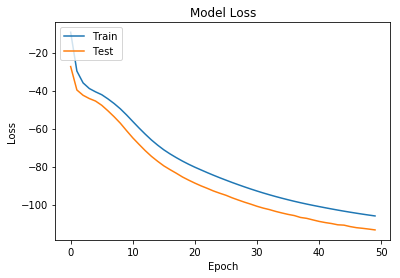

In [64]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()